# Step #1 Load the Data

In [1]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates  
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
today = date.today()
date_today = today.strftime("%Y-%m-%d")
stockname = 'NASDAQ'
date_start = '2016-01-04'

df=pd.read_csv(r'https://raw.githubusercontent.com/Fluid-AI/marketprophecy/main/NASDAQ%20Data/NASDAQ%20Training%20Data%20-%201st%20Jan%202016%20to%201st%20Jan%202022.csv',index_col=['Date'])
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,4897.649902,4903.089844,4846.979980,4903.089844,4903.089844,2218420000
2016-01-05,4917.839844,4926.729980,4872.740234,4891.430176,4891.430176,1927380000
2016-01-06,4813.759766,4866.040039,4804.689941,4835.759766,4835.759766,2168620000
2016-01-07,4736.399902,4788.020020,4688.169922,4689.430176,4689.430176,2552590000
2016-01-08,4722.020020,4742.569824,4637.850098,4643.629883,4643.629883,2288750000


# Step #2 Exploring the Data

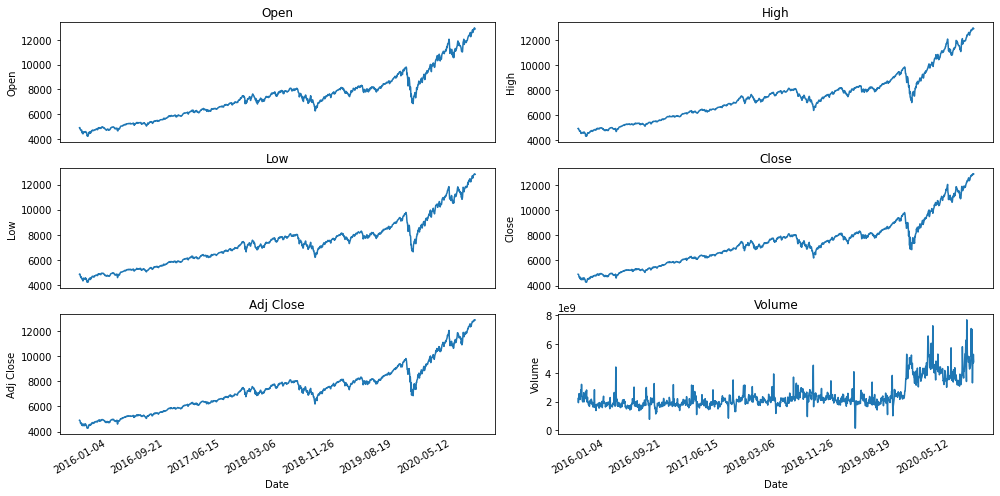

In [2]:
# Plot line charts
df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [3]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()
train_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,4897.649902,4903.089844,4846.979980,4903.089844,4903.089844,2218420000
2016-01-05,4917.839844,4926.729980,4872.740234,4891.430176,4891.430176,1927380000
2016-01-06,4813.759766,4866.040039,4804.689941,4835.759766,4835.759766,2168620000
2016-01-07,4736.399902,4788.020020,4688.169922,4689.430176,4689.430176,2552590000
2016-01-08,4722.020020,4742.569824,4637.850098,4643.629883,4643.629883,2288750000
...,...,...,...,...,...,...
2020-12-24,12791.540039,12833.549805,12767.639648,12804.730469,12804.730469,3305950000
2020-12-28,12914.639648,12930.889648,12827.450195,12899.419922,12899.419922,5076340000
2020-12-29,12965.389648,12973.330078,12821.959961,12850.219727,12850.219727,4680780000


In [4]:
date_index = train_df.index
date_index

Index(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
       '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15',
       ...
       '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
       '2020-12-24', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31'],
      dtype='object', name='Date', length=1259)

In [5]:
# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
d

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [6]:
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 


In [7]:
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Month,Year
0,4897.649902,4903.089844,4846.979980,4903.089844,4903.089844,2218420000,01,2016
1,4917.839844,4926.729980,4872.740234,4891.430176,4891.430176,1927380000,01,2016
2,4813.759766,4866.040039,4804.689941,4835.759766,4835.759766,2168620000,01,2016
3,4736.399902,4788.020020,4688.169922,4689.430176,4689.430176,2552590000,01,2016
4,4722.020020,4742.569824,4637.850098,4643.629883,4643.629883,2288750000,01,2016


In [8]:
# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close',
            'Volume','Month']

In [9]:
print([f for f in FEATURES])

['High', 'Low', 'Open', 'Close', 'Volume', 'Month']


In [10]:
# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]
data_filtered

,High,Low,Open,Close,Volume,Month
0,4903.089844,4846.979980,4897.649902,4903.089844,2218420000,01
1,4926.729980,4872.740234,4917.839844,4891.430176,1927380000,01
2,4866.040039,4804.689941,4813.759766,4835.759766,2168620000,01
3,4788.020020,4688.169922,4736.399902,4689.430176,2552590000,01
4,4742.569824,4637.850098,4722.020020,4643.629883,2288750000,01
...,...,...,...,...,...,...
1254,12833.549805,12767.639648,12791.540039,12804.730469,3305950000,12
1255,12930.889648,12827.450195,12914.639648,12899.419922,5076340000,12
1256,12973.330078,12821.959961,12965.389648,12850.219727,4680780000,12
1257,12924.929688,12857.759766,12906.509766,12870.000000,5292210000,12


In [11]:
# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']


In [12]:
# Print the tail of the dataframe
data_filtered_ext.head()

,High,Low,Open,Close,Volume,Month,Prediction
0,4903.089844,4846.979980,4897.649902,4903.089844,2218420000,01,4903.089844
1,4926.729980,4872.740234,4917.839844,4891.430176,1927380000,01,4891.430176
2,4866.040039,4804.689941,4813.759766,4835.759766,2168620000,01,4835.759766
3,4788.020020,4688.169922,4736.399902,4689.430176,2552590000,01,4689.430176
4,4742.569824,4637.850098,4722.020020,4643.629883,2288750000,01,4643.629883


In [13]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]
nrows

1259

In [14]:
# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data_unscaled.shape

(1259, 6)

In [15]:
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

(1259, 6)


In [16]:
np_data

array([[4903.089844, 4846.97998, 4897.649902, 4903.089844, 2218420000,
        '01'],
       [4926.72998, 4872.740234, 4917.839844, 4891.430176, 1927380000,
        '01'],
       [4866.040039, 4804.689941, 4813.759766, 4835.759766, 2168620000,
        '01'],
       ...,
       [12973.330078, 12821.959961, 12965.389648, 12850.219727,
        4680780000, '12'],
       [12924.929688, 12857.759766, 12906.509766, 12870.0, 5292210000,
        '12'],
       [12902.070313, 12821.230469, 12877.089844, 12888.280273,
        4771390000, '12']], dtype=object)

In [17]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

In [18]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
df_Close

,Close
0,4903.089844
1,4891.430176
2,4835.759766
3,4689.430176
4,4643.629883
...,...
1254,12804.730469
1255,12899.419922
1256,12850.219727
1257,12870.000000


In [19]:
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [20]:
sequence_length = 50

In [21]:
index_Close = data.columns.get_loc("Close")

In [22]:
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
train_data_len

1008

In [23]:
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [24]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    x = np.array(x)
    y = np.array(y)
    return x, y

In [25]:
 #Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)


In [26]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(958, 50, 6) (958,)
(251, 50, 6) (251,)


In [27]:
x_train

array([[[0.07026059, 0.07368411, 0.07761204, 0.07370334, 0.27425829,
         0.        ],
        [0.07298407, 0.07666287, 0.07992036, 0.07235268, 0.23567939,
         0.        ],
        [0.06599223, 0.06879396, 0.06802084, 0.06590381, 0.26765703,
         0.        ],
        ...,
        [0.05248434, 0.05679352, 0.05643004, 0.05579217, 0.21903176,
         0.18181818],
        [0.05403731, 0.06033187, 0.05883215, 0.05600179, 0.19428501,
         0.18181818],
        [0.05092675, 0.05808396, 0.05857491, 0.0534985 , 0.20453419,
         0.18181818]],

       [[0.07298407, 0.07666287, 0.07992036, 0.07235268, 0.23567939,
         0.        ],
        [0.06599223, 0.06879396, 0.06802084, 0.06590381, 0.26765703,
         0.        ],
        [0.05700386, 0.05532032, 0.05917626, 0.04895296, 0.3185543 ,
         0.        ],
        ...,
        [0.05403731, 0.06033187, 0.05883215, 0.05600179, 0.19428501,
         0.18181818],
        [0.05092675, 0.05808396, 0.05857491, 0.0534985 , 0.204

In [28]:
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

0.05758769296179822
0.05758769296179822


# Step #4 Model Training

In [29]:
# Configure the neural network model
model = Sequential()
n_neurons = x_train.shape[1] * x_train.shape[2]

In [30]:
print(n_neurons, x_train.shape[1], x_train.shape[2])

300 50 6


In [31]:
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))


In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [33]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
60/60 [==============================] - 26s 372ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 2/50
60/60 [==============================] - 20s 337ms/step - loss: 2.6378e-04 - val_loss: 0.0050
Epoch 3/50
60/60 [==============================] - 20s 336ms/step - loss: 2.2834e-04 - val_loss: 0.0037
Epoch 4/50
60/60 [==============================] - 18s 296ms/step - loss: 2.1125e-04 - val_loss: 0.0032
Epoch 5/50
60/60 [==============================] - 19s 324ms/step - loss: 1.9858e-04 - val_loss: 0.0047
Epoch 6/50
60/60 [==============================] - 19s 315ms/step - loss: 2.1609e-04 - val_loss: 0.0031
Epoch 7/50
60/60 [==============================] - 21s 350ms/step - loss: 2.2405e-04 - val_loss: 0.0020
Epoch 8/50
60/60 [==============================] - 25s 413ms/step - loss: 2.2806e-04 - val_loss: 0.0044
Epoch 9/50
60/60 [==============================] - 23s 381ms/step - loss: 2.3792e-04 - val_loss: 0.0022
Epoch 10/50
60/60 [==============================] - 21s 35

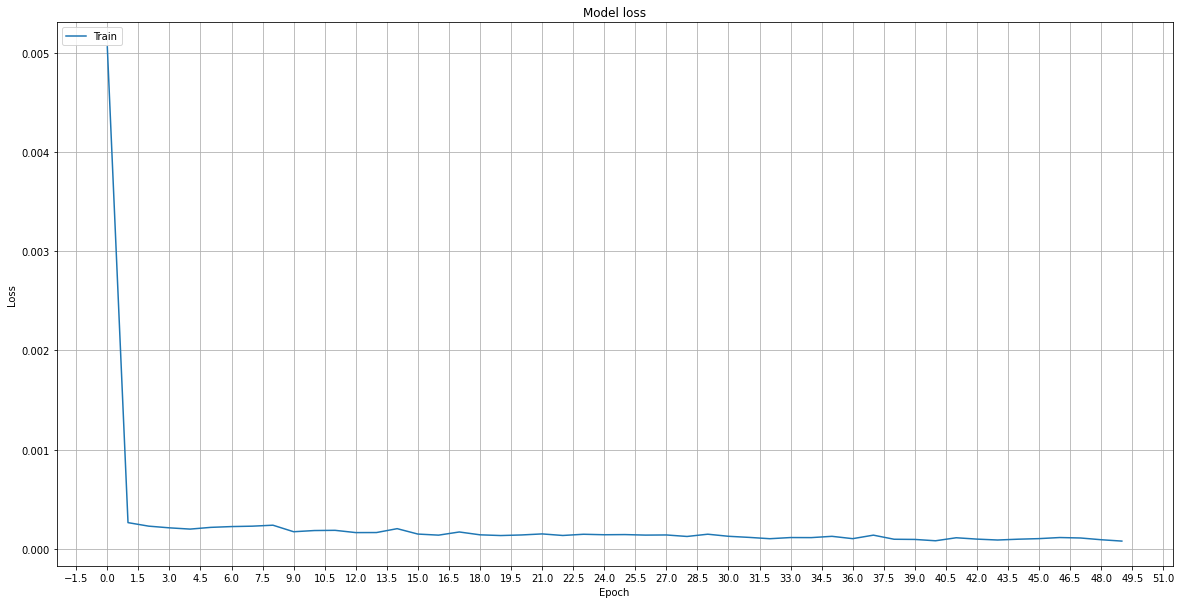

In [34]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [35]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

In [36]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [37]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

Median Absolute Error (MAE): 166.3


In [38]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 1.7 %


In [39]:
# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Percentage Error (MDAPE): 1.43 %
